In [1]:
import sys
sys.path.append("../")
from simulators.extended_particle_model import generate_mixture_model

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# model parameters: need to obey the hierarchy: sig_sigma_truth < bkg_sigma_truth < sig_mean_prior_sigma
sigfrac_truth = 0.2
sig_mean_truth, sig_sigma_truth = 1.0, 0.1
bkg_mean_truth, bkg_sigma_truth = 0.0, 1.0
sig_mean_prior_mu, sig_mean_prior_sigma = 1.0, 2.0
num_evts = 100

In [4]:
from models.utils import build_mlp
import pytorch_lightning as pl
import torch.distributions as dist

class DeepSet(pl.LightningModule):

    def __init__(self, optimizer = torch.optim.AdamW, optimizer_kwargs = {"weight_decay": 1e-2}, lr = 1e-3,
                 max_epochs = 10, input_dim = 1, embedding_dim = 64, hidden_dim = 128, layers = 2):
        super().__init__()

        self.max_epochs = max_epochs
        self.optimizer = optimizer
        self.lr = lr
        self.optimizer_kwargs = optimizer_kwargs

        self.enc = build_mlp(input_dim = input_dim, output_dim = embedding_dim, 
                                hidden_dim = hidden_dim, layers = layers)
        self.dec = build_mlp(input_dim = embedding_dim, output_dim = 2,
                                hidden_dim = hidden_dim, layers = layers)

    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr = self.lr, **self.optimizer_kwargs)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = self.max_epochs)
        return {"optimizer": optimizer, 
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 1
                    }
                }

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred_mu, pred_sigma = self.forward(x)
        loss = -dist.Normal(pred_mu, pred_sigma).log_prob(y).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred_mu, pred_sigma = self.forward(x)
        loss = -dist.Normal(pred_mu, pred_sigma).log_prob(y).mean()
        self.log("val_loss", loss)
        return loss

    def forward(self, x):
        embedding = self.enc.forward(x).mean(-2)
        pred = self.dec(embedding)
        pred_mu, pred_log_sigma = torch.chunk(pred, 2, -1)
        pred_sigma = pred_log_sigma.exp()
        return pred_mu, pred_sigma


In [5]:
model_ds = DeepSet.load_from_checkpoint("/path/to/DeepSet/model")

In [6]:
def make_datasets_x(dset_length, num_dsets, sigfrac, sig_mean):

    data = [np.expand_dims(generate_mixture_model(dset_length, sigfrac = sigfrac, sigdist = (sig_mean, sig_sigma_truth), 
                                                    bkgdist = (bkg_mean_truth, bkg_sigma_truth)), -1) for cur in range(num_dsets)]

    return data

In [ ]:
sig_means_deepset = np.linspace(-1, 3, 1000)
means_mu_deepset = []
means_sigma_deepset = []

for cur_sig_mean in sig_means_deepset:
    eval_data = torch.Tensor(make_datasets_x(dset_length = 100, num_dsets = 1000, sigfrac = sigfrac_truth, sig_mean = cur_sig_mean))
    pred_mu, pred_sigma = model_ds.forward(eval_data)
    means_mu_deepset.append(np.median(pred_mu.detach().numpy()))
    means_sigma_deepset.append(np.median(pred_sigma.detach().numpy()))

means_mu_deepset = np.array(means_mu_deepset)
means_sigma_deepset = np.array(means_sigma_deepset)

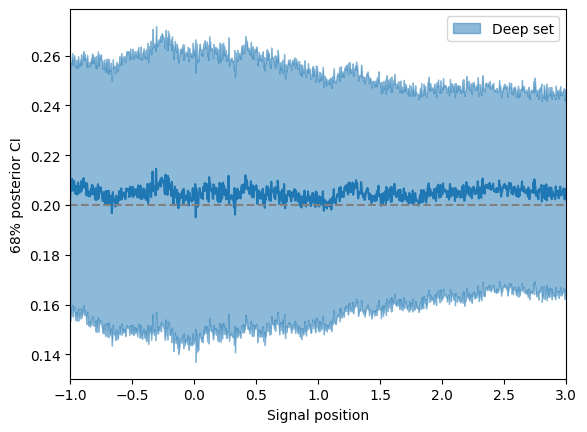

In [8]:
plt.fill_between(sig_means_deepset, means_mu_deepset - means_sigma_deepset, means_mu_deepset + means_sigma_deepset, alpha = 0.5, color = "tab:blue", label = "Deep set")
plt.plot(sig_means_deepset, means_mu_deepset, color = "tab:blue")
plt.axhline(sigfrac_truth, c = "gray", ls = "dashed")
plt.margins(x = 0)
plt.xlabel("Signal position")
plt.ylabel("68% posterior CI")
plt.legend()

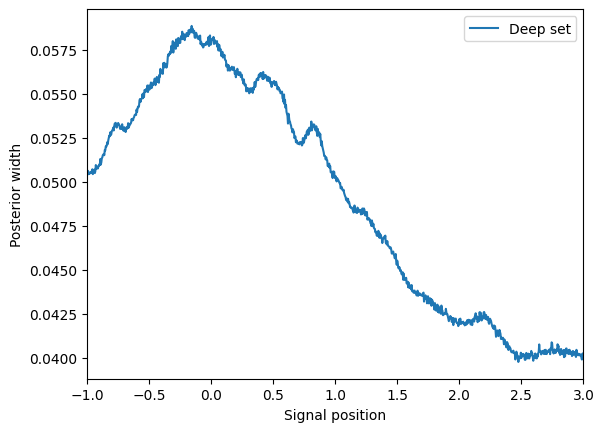

In [9]:
plt.plot(sig_means_deepset, means_sigma_deepset, color = "tab:blue", label = "Deep set")
plt.margins(x = 0)
plt.xlabel("Signal position")
plt.ylabel("Posterior width")
plt.legend()

# Read results from MCMC campaign

In [10]:
import yaml, os, pickle, glob

In [11]:
def load_data(campaigndir, POI_name = "sigfrac", models = ["MCMC_x", "MCMC_clf_nom", "MCMC_clf_marg"]):
    configpath = os.path.join(campaigndir, "config.yaml")

    if not os.path.exists(configpath):
        return None

    with open(configpath, 'r') as configfile:
        config = yaml.safe_load(configfile)

    POI_means = {model: [] for model in models}
    POI_sigmas = {model: [] for model in models}

    for resfile_path in glob.glob(os.path.join(campaigndir, "output", "*.pkl")):
        with open(resfile_path, 'rb') as resfile:
            data = pickle.load(resfile)
            for model in models:
                POI_means[model] += data[f"means_{POI_name}"][model]
                POI_sigmas[model] += data[f"sigmas_{POI_name}"][model]
            
    retdict = {"POI_val_truth": config[POI_name],
               "sig_mean": config["sig_mean"]
    }

    retdict["POI_mu_median"] = {model: np.median(POI_means[model]) for model in models}
    retdict["POI_sigma_median"] = {model: np.median(POI_sigmas[model]) for model in models}

    return retdict

In [12]:
campaign_rootdir = "/path/to/MCMC/campaign/"

In [13]:
all_data = [load_data(cur_dir) for cur_dir in glob.glob(os.path.join(campaign_rootdir, '*'))]
all_data = [cur_data for cur_data in all_data if cur_data is not None]

In [14]:
sig_means = []
POI_mu_median_MCMC_x = []
POI_mu_median_MCMC_clf_nom = []
POI_mu_median_MCMC_clf_marg = []
POI_sigma_median_MCMC_x = []
POI_sigma_median_MCMC_clf_nom = []
POI_sigma_median_MCMC_clf_marg = []

for data in all_data:
    sig_means.append(data["sig_mean"])
    POI_mu_median_MCMC_x.append(data["POI_mu_median"]["MCMC_x"])
    POI_mu_median_MCMC_clf_nom.append(data["POI_mu_median"]["MCMC_clf_nom"])
    POI_mu_median_MCMC_clf_marg.append(data["POI_mu_median"]["MCMC_clf_marg"])
    POI_sigma_median_MCMC_x.append(data["POI_sigma_median"]["MCMC_x"])
    POI_sigma_median_MCMC_clf_nom.append(data["POI_sigma_median"]["MCMC_clf_nom"])
    POI_sigma_median_MCMC_clf_marg.append(data["POI_sigma_median"]["MCMC_clf_marg"])

sorter = np.argsort(sig_means)
sig_means = np.array(sig_means)[sorter]
POI_mu_median_MCMC_x = np.array(POI_mu_median_MCMC_x)[sorter]
POI_mu_median_MCMC_clf_nom = np.array(POI_mu_median_MCMC_clf_nom)[sorter]
POI_mu_median_MCMC_clf_marg = np.array(POI_mu_median_MCMC_clf_marg)[sorter]
POI_sigma_median_MCMC_x = np.array(POI_sigma_median_MCMC_x)[sorter]
POI_sigma_median_MCMC_clf_nom = np.array(POI_sigma_median_MCMC_clf_nom)[sorter]
POI_sigma_median_MCMC_clf_marg = np.array(POI_sigma_median_MCMC_clf_marg)[sorter]

In [19]:
sig_means

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
        1.25,  1.5 ,  1.75,  2.  ,  2.2 ,  2.4 ,  2.6 ,  2.8 ,  3.  ])

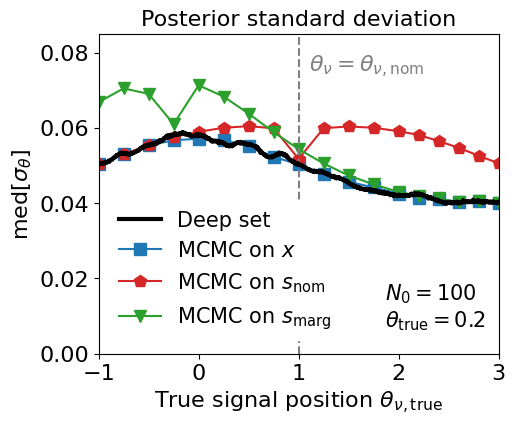

In [148]:
fig, ax = plt.subplots(figsize = (5, 4.1))
ax.plot(sig_means_deepset, means_sigma_deepset, color = "black", label = "Deep set", lw = 3, zorder = 100)
ax.plot(sig_means, POI_sigma_median_MCMC_x, color = "tab:blue", label = r"MCMC on $x$", marker = "s", ms = 9)
ax.plot(sig_means, POI_sigma_median_MCMC_clf_nom, color = "tab:red", label = r"MCMC on $s_{\mathrm{nom}}$", marker = "p", ms = 9)
ax.plot(sig_means, POI_sigma_median_MCMC_clf_marg, color = "tab:green", label = r"MCMC on $s_{\mathrm{marg}}$", marker = "v", ms = 9)
ax.margins(x = 0)
ax.set_xlabel(r"True signal position $\theta_{\nu, \mathrm{true}}$", fontsize = 16)
ax.set_ylabel(r"$\mathrm{med}[\sigma_{\theta}]$", fontsize = 16)
ax.axvline(1.0, color = "gray", ls = "dashed")
ax.set_xlim(-1.0, 3.0)
ax.set_ylim(0.0, 0.085)
ax.legend(frameon = True, prop = {'size': 15},
          bbox_to_anchor = (0.63, 0.01), loc = "lower right",
          facecolor = "white", edgecolor = "white", framealpha = 1)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.text(1.1, 0.075, r"$\theta_{\nu} = \theta_{\nu, \mathrm{nom}}}$", fontsize = 16, color = "gray")
ax.text(1.86, 0.007, "\n".join(["$N_0 = 100$", r"$\theta_{\mathrm{true}} = 0.2$"]), fontsize = 15)
plt.subplots_adjust(left = 0.18, right = 0.98, bottom = 0.15, top = 0.93, wspace = 0.25, hspace = 0.08)
ax.set_title("Posterior standard deviation", fontsize = 16)
fig.savefig("posterior_width.pdf")

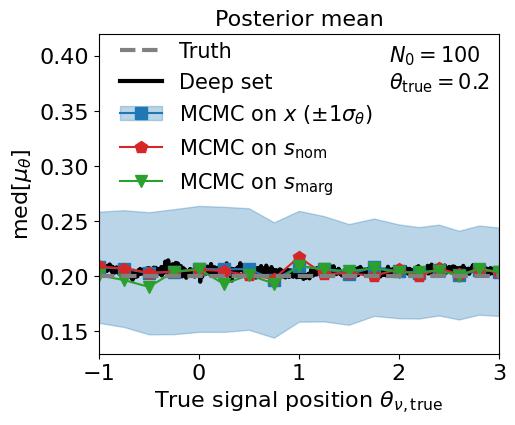

In [144]:
fig, ax = plt.subplots(figsize = (5, 4.1))

ax.fill_between(sig_means, POI_mu_median_MCMC_x - POI_sigma_median_MCMC_x, POI_mu_median_MCMC_x + POI_sigma_median_MCMC_x, alpha = 0.3, color = "tab:blue")
p_deepset = ax.plot(sig_means_deepset, means_mu_deepset, color = "black", lw = 3)
p_MCMX_x = ax.plot(sig_means, POI_mu_median_MCMC_x, color = "tab:blue", marker = "s", ms = 9)
p_MCMC_fill = ax.fill(np.NaN, np.NaN, color = "tab:blue", alpha = 0.3)
p_MCMC_clf_nom = ax.plot(sig_means, POI_mu_median_MCMC_clf_nom, color = "tab:red", marker = "p", ms = 9)
p_MCMC_clf_marg = ax.plot(sig_means, POI_mu_median_MCMC_clf_marg, color = "tab:green", marker = "v", ms = 9)
p_truth = ax.plot(sig_means, np.full_like(sig_means, sigfrac_truth), c = "gray", ls = "dashed", lw = 3)
ax.margins(x = 0)
ax.set_ylim(0.13, 0.42)
ax.set_xlabel(r"True signal position $\theta_{\nu, \mathrm{true}}$", fontsize = 16)
ax.set_ylabel(r"$\mathrm{med}[\mu_\theta]$", fontsize = 16)
ax.legend([p_truth[0],
            p_deepset[0],
           (p_MCMC_fill[0], p_MCMX_x[0]),
           p_MCMC_clf_nom[0],
           p_MCMC_clf_marg[0]
           ], 
           ["Truth",
            "Deep set",
            r"MCMC on $x$ ($\pm 1 \sigma_{\theta}$)", 
            "MCMC on $s_{\mathrm{nom}}$",
            "MCMC on $s_{\mathrm{marg}}$"
            ], 
            frameon = False, ncol = 1, prop = {'size': 15},
            bbox_to_anchor = (0.73, 0.43), loc = "lower right")
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.text(1.9, 0.37, "\n".join(["$N_0 = 100$", r"$\theta_{\mathrm{true}} = 0.2$"]), fontsize = 15)
plt.subplots_adjust(left = 0.18, right = 0.98, bottom = 0.15, top = 0.93, wspace = 0.25, hspace = 0.08)
ax.set_title("Posterior mean", fontsize = 16)
fig.savefig("posterior_mean.pdf")